### 2023-06-16 cloud condensate vs. radiative effect

What is the relationship between column-integrated cloud condensate and the cloud radiative effects? Look at data from the radiation port of the FV3GFS RRTMG scheme, as well as from the coarsened SHiELD RRTMG scheme.

In [1]:
import intake
import xarray as xr
import numpy as np
import os
import cftime
import dataclasses
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
from vcm.calc.thermo.vertically_dependent import mass_integrate
from vcm import histogram2d
from vcm.catalog import catalog as CATALOG
from dask.distributed import Client

In [2]:
COARSENED_FINE_CLOUD_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-training-data.zarr'
COARSENED_FINE_CLOUD_RADIATION_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run'
PREDICTED_CLOUD_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/predicted-fine-cloud-fields-seed-0-squash-threshold-0.zarr'
PREDICTED_CLOUD_RADIATION_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0/fv3gfs_run'

In [3]:
CLOUD_VARIABLES = [
    'cloud_amount',
    'cloud_ice_mixing_ratio',
    'cloud_water_mixing_ratio'
]
HORIZONTAL_DIMS = ['tile', 'x', 'y']
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 8, 7, 0, 30, 0),
    cftime.DatetimeJulian(2020, 8, 9, 23, 30, 0),
    4
) # hourly over days 8-10 validation
GRID = CATALOG['grid/c48'].read()
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']
QUANTILES = [0.90, 0.50, 0.10]
plt.rcParams['font.size'] = 8
OUTDIR = 'figures'

In [4]:
@dataclasses.dataclass
class RadiationDiag:
    fortran_diag_name: str
    python_diag_name: str
    scale: float
    
FLUXES = [
    RadiationDiag('DSWRFtoa', 'total_sky_downward_shortwave_flux_at_top_of_atmosphere', 2.0),
    RadiationDiag('DCSWRFsfc', 'clear_sky_downward_shortwave_flux_at_surface', 2.0),
    RadiationDiag('UCSWRFsfc', 'clear_sky_upward_shortwave_flux_at_surface', 2.0),
    RadiationDiag('UCSWRFtoa', 'clear_sky_upward_shortwave_flux_at_top_of_atmosphere', 2.0),
    RadiationDiag('DCLWRFsfc', 'clear_sky_downward_longwave_flux_at_surface', 2.0),
    RadiationDiag('UCLWRFsfc', 'clear_sky_upward_longwave_flux_at_surface', 2.0),
    RadiationDiag('UCLWRFtoa', 'clear_sky_upward_longwave_flux_at_top_of_atmosphere', 2.0),
    RadiationDiag('DSWRFsfc', 'total_sky_downward_shortwave_flux_at_surface', 100.0),
    RadiationDiag('USWRFsfc', 'total_sky_upward_shortwave_flux_at_surface', 100.0),
    RadiationDiag('USWRFtoa', 'total_sky_upward_shortwave_flux_at_top_of_atmosphere', 100.0),
    RadiationDiag('DLWRFsfc', 'total_sky_downward_longwave_flux_at_surface', 30.0),
    RadiationDiag('ULWRFsfc', 'total_sky_upward_longwave_flux_at_surface', 30.0),
    RadiationDiag('ULWRFtoa', 'total_sky_upward_longwave_flux_at_top_of_atmosphere', 30.0),
    RadiationDiag('N/A', 'downward_total_sky_shortwave_transmissivity', 0.10),
    RadiationDiag('N/A', 'downward_clear_sky_shortwave_transmissivity', 0.10),
    RadiationDiag('N/A', 'downward_shortwave_cre', 0.10),
    RadiationDiag('N/A', 'downward_longwave_cre', 0.10),
    RadiationDiag('N/A', 'upward_total_sky_shortwave_transmissivity', 0.10),
    RadiationDiag('N/A', 'upward_clear_sky_shortwave_transmissivity', 0.10),
    RadiationDiag('N/A', 'upward_total_sky_longwave_transmissivity', 0.10),
    RadiationDiag('N/A', 'upward_clear_sky_longwave_transmissivity', 0.10),
    RadiationDiag('N/A', 'upward_shortwave_cre', 0.10),
    RadiationDiag('N/A', 'upward_longwave_cre', 0.10),
]

In [5]:
def get_downward_shortwave_cre(
    downward_total_shortwave_flux_toa,
    downward_total_shortwave_flux_sfc,
    downward_clear_shortwave_flux_sfc,
):
    downward_clear_shortwave_transmissivity = downward_clear_shortwave_flux_sfc / downward_total_shortwave_flux_toa 
    downward_clear_shortwave_transmissivity = (
        downward_clear_shortwave_transmissivity
        .where(~np.isnan(downward_clear_shortwave_transmissivity), 0.0)
        .assign_attrs({'long_name': f'downward clear sky shortwave transmissivity', 'units': '[-]'})
    )
    downward_total_shortwave_transmissivity = downward_total_shortwave_flux_sfc / downward_total_shortwave_flux_toa 
    downward_total_shortwave_transmissivity = (
        downward_total_shortwave_transmissivity
        .where(~np.isnan(downward_total_shortwave_transmissivity), 0.0)
        .assign_attrs({'long_name': f'downward total sky shortwave transmissivity', 'units': '[-]'})
    )
    downward_shortwave_cre = (
        (1.0 - (downward_total_shortwave_transmissivity / downward_clear_shortwave_transmissivity))
        .assign_attrs({'long_name': f'downward shortwave normalized cloud radiative effect', 'units': 'fraction'})
    )
    return xr.Dataset({
        f'downward_clear_sky_shortwave_transmissivity': downward_clear_shortwave_transmissivity,
        f'downward_total_sky_shortwave_transmissivity': downward_total_shortwave_transmissivity,
        f'downward_shortwave_cre': downward_shortwave_cre
    })


def get_upward_shortwave_cre(
    upward_total_shortwave_flux_toa,
    upward_clear_shortwave_flux_toa,
    upward_total_shortwave_flux_sfc,
    upward_clear_shortwave_flux_sfc,
):
    upward_clear_transmissivity = upward_clear_shortwave_flux_toa / upward_clear_shortwave_flux_sfc 
    upward_clear_transmissivity = (
        upward_clear_transmissivity
        .where(~np.isnan(upward_clear_transmissivity), 0.0)
        .assign_attrs({'long_name': f'upward clear sky shortwave transmissivity', 'units': '[-]'})
    )
    upward_total_transmissivity = upward_total_shortwave_flux_toa / upward_total_shortwave_flux_sfc 
    upward_total_transmissivity = (
        upward_total_transmissivity
        .where(~np.isnan(upward_total_transmissivity), 0.0)
        .assign_attrs({'long_name': f'upward total sky shortwave transmissivity', 'units': '[-]'})
    )
    upward_shortwave_cre = (
        (1.0 - (upward_total_transmissivity / upward_clear_transmissivity))
        .assign_attrs({'long_name': f'upward shortwave normalized cloud radiative effect', 'units': 'fraction'})
    )
    return xr.Dataset({
        f'upward_clear_sky_shortwave_transmissivity': upward_clear_transmissivity,
        f'upward_total_sky_shortwave_transmissivity': upward_total_transmissivity,
        f'upward_shortwave_cre': upward_shortwave_cre
    })

def get_downward_longwave_cre(
    downward_total_longwave_flux_sfc,
    downward_clear_longwave_flux_sfc
):
    downward_longwave_cre = ((downward_total_longwave_flux_sfc / downward_clear_longwave_flux_sfc)
        .assign_attrs({'long_name': f'downward longwave normalized cloud radiative effect', 'units': 'fraction'})
    )
    return xr.Dataset({'downward_longwave_cre': downward_longwave_cre})

def get_upward_longwave_cre(
    upward_total_longwave_flux_toa,
    upward_clear_longwave_flux_toa,
    upward_total_longwave_flux_sfc,
    upward_clear_longwave_flux_sfc
):
    upward_clear_longwave_transmissivity = upward_clear_longwave_flux_toa / upward_clear_longwave_flux_sfc 
    upward_clear_longwave_transmissivity = (
        upward_clear_longwave_transmissivity
        .where(~np.isnan(upward_clear_longwave_transmissivity), 0.0)
        .assign_attrs({'long_name': f'upward clear sky longwave transmissivity', 'units': '[-]'})
    )
    upward_total_longwave_transmissivity = upward_total_longwave_flux_toa / upward_total_longwave_flux_sfc 
    upward_total_longwave_transmissivity = (
        upward_total_longwave_transmissivity
        .where(~np.isnan(upward_total_longwave_transmissivity), 0.0)
        .assign_attrs({'long_name': f'upward total sky longwave transmissivity', 'units': '[-]'})
    )
    upward_longwave_cre = (
        (1.0 - (upward_total_longwave_transmissivity / upward_clear_longwave_transmissivity))
        .assign_attrs({'long_name': f'upward longwave normalized cloud radiative effect', 'units': 'fraction'})
    )
    return xr.Dataset({
        f'upward_clear_sky_longwave_transmissivity': upward_clear_longwave_transmissivity,
        f'upward_total_sky_longwave_transmissivity': upward_total_longwave_transmissivity,
        f'upward_longwave_cre': upward_longwave_cre
    })

In [6]:
def add_cloud_condensate(cloud_ice_mixing_ratio, cloud_water_mixing_ratio):
    cloud_condensate_mixing_ratio = cloud_ice_mixing_ratio + cloud_water_mixing_ratio
    return cloud_condensate_mixing_ratio.assign_attrs({'long_name': 'cloud condensate mixing ratio', 'units': 'kg/kg'})

def add_column_integrated_vars(ds, delp):
    for var in ds.data_vars:
        if "mixing_ratio" in var:
            result = mass_integrate(ds[var], delp, dim='z')
            path_name = var.split('_mixing_ratio')[0].replace('_', ' ') + ' path'
            result = result.assign_attrs({'long_name': path_name, 'units': r'$kg/{m^2}$'})
        elif "amount" in var:
            result = ds[var].weighted(delp).mean(dim='z')
            result = result.assign_attrs({'long_name': 'column-averaged cloud amount', 'units': 'fraction'})
        ds[f"column_integrated_{var}"] = result
    return ds

def get_zarr_fluxes(rundir, zarrname='radiative_fluxes'):
    print(os.path.join(rundir, zarrname + '.zarr'))
    try:
        ds = xr.open_zarr(os.path.join(rundir, zarrname + '.zarr'), consolidated=True)
    except KeyError:
        ds = xr.open_zarr(os.path.join(rundir, zarrname + '.zarr'), consolidated=False)
    ds = rename_python_fluxes(ds)
    ds = ds.merge(get_downward_shortwave_cre(
        ds.total_sky_downward_shortwave_flux_at_top_of_atmosphere,
        ds.total_sky_downward_shortwave_flux_at_surface,
        ds.clear_sky_downward_shortwave_flux_at_surface,
    ))
    ds = ds.merge(get_upward_shortwave_cre(
        ds.total_sky_upward_shortwave_flux_at_top_of_atmosphere,
        ds.clear_sky_upward_shortwave_flux_at_top_of_atmosphere,
        ds.total_sky_upward_shortwave_flux_at_surface,
        ds.clear_sky_upward_shortwave_flux_at_surface,
    ))
    ds = ds.merge(get_downward_longwave_cre(
        ds.total_sky_downward_longwave_flux_at_surface,
        ds.clear_sky_downward_longwave_flux_at_surface,
    ))
    ds = ds.merge(get_upward_longwave_cre(
        ds.total_sky_upward_longwave_flux_at_top_of_atmosphere,
        ds.clear_sky_upward_longwave_flux_at_top_of_atmosphere,
        ds.total_sky_upward_longwave_flux_at_surface,
        ds.clear_sky_upward_longwave_flux_at_surface,
    ))
    ds = subset_fluxes(ds)
    return ds

def rename_python_fluxes(ds):
    ds_rename = xr.Dataset()
    for diag in FLUXES:
        name_with_suffix = diag.python_diag_name + "_python"
        if name_with_suffix in ds:
            ds_rename[diag.python_diag_name] = ds[name_with_suffix]
    return ds_rename

def subset_fluxes(ds):
    ds_out = xr.Dataset()
    for diag in FLUXES:
        ds_out[diag.python_diag_name] = ds[diag.python_diag_name]
    return ds_out

def area_weighted_mean(ds, dims=HORIZONTAL_DIMS):
    return ds.weighted(GRID.area).mean(dim=dims)

In [7]:
coarse_delp = xr.open_zarr(COARSENED_FINE_CLOUD_PATH)['pressure_thickness_of_atmospheric_layer']

In [8]:
coarsened_fine_cloud = xr.open_zarr(COARSENED_FINE_CLOUD_PATH)[CLOUD_VARIABLES]
coarsened_fine_cloud = coarsened_fine_cloud.assign(
    cloud_condensate_mixing_ratio=add_cloud_condensate(coarsened_fine_cloud.cloud_ice_mixing_ratio, coarsened_fine_cloud.cloud_water_mixing_ratio)
)
coarsened_fine_cloud = add_column_integrated_vars(coarsened_fine_cloud, coarse_delp)

In [9]:
predicted_cloud = xr.open_zarr(PREDICTED_CLOUD_PATH)[CLOUD_VARIABLES]
predicted_cloud = predicted_cloud.assign(
    cloud_condensate_mixing_ratio=add_cloud_condensate(predicted_cloud.cloud_ice_mixing_ratio, predicted_cloud.cloud_water_mixing_ratio)
)
predicted_cloud = add_column_integrated_vars(predicted_cloud, coarse_delp)

In [10]:
coarsened_fine_cloud_radiation = get_zarr_fluxes(COARSENED_FINE_CLOUD_RADIATION_PATH)
predicted_cloud_radiation = get_zarr_fluxes(PREDICTED_CLOUD_RADIATION_PATH)

gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0/fv3gfs_run/radiative_fluxes.zarr


In [11]:
coarsened_fine_cloud_radiation = coarsened_fine_cloud_radiation.merge(coarsened_fine_cloud, join='inner').sel(time=TIME_SLICE)
predicted_cloud_radiation = predicted_cloud_radiation.merge(predicted_cloud, join='inner')

In [12]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34595,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:41893,Total threads: 2
Dashboard: http://127.0.0.1:43717/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:42247,


In [13]:
valid_columns = (
    ~np.isnan(predicted_cloud_radiation.downward_shortwave_cre) 
    & ~np.isnan(coarsened_fine_cloud_radiation.downward_shortwave_cre)
)

valid_columns.sum().load()

<xarray.DataArray 'downward_shortwave_cre' ()>
array(506027)

In [14]:
y = coarsened_fine_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio.where(valid_columns).stack({'sample': ['time', 'tile', 'x', 'y']}).dropna(dim='sample')

In [15]:
x = -np.log(1 - (coarsened_fine_cloud_radiation.downward_shortwave_cre.where(valid_columns).stack({'sample': ['time', 'tile', 'x', 'y']})).dropna(dim='sample'))

In [16]:
valid_columns_2 = ~np.isinf(x)

In [17]:
x, y = x.where(valid_columns_2).dropna(dim='sample'), y.where(valid_columns_2).dropna(dim='sample')

In [18]:
c0_coarsened_fine = (x * y).sum() / (x * x).sum()

In [19]:
c0_coarsened_fine.compute()

<xarray.DataArray ()>
array(0.29656865)

In [20]:
y = predicted_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio.where(valid_columns).stack({'sample': ['time', 'tile', 'x', 'y']}).dropna(dim='sample')

In [21]:
x = -np.log(1 - (predicted_cloud_radiation.downward_shortwave_cre.where(valid_columns).stack({'sample': ['time', 'tile', 'x', 'y']})).dropna(dim='sample'))

In [22]:
valid_columns_3 = ~np.isinf(x)

In [23]:
x, y = x.where(valid_columns_3).dropna(dim='sample'), y.where(valid_columns_3).dropna(dim='sample')

In [24]:
c0_predicted = (x * y).sum() / (x * x).sum()

In [25]:
c0_predicted.compute()

<xarray.DataArray ()>
array(0.27084269)

In [26]:
coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio = coarsened_fine_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio.where(valid_columns)
coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean = area_weighted_mean(coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio).mean('time')
coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean.load()

coarsened_fine_cloud_downward_shortwave_cre = coarsened_fine_cloud_radiation.downward_shortwave_cre.where(valid_columns)
coarsened_fine_cloud_downward_shortwave_cre_mean = area_weighted_mean(coarsened_fine_cloud_downward_shortwave_cre).mean('time')
coarsened_fine_cloud_downward_shortwave_cre_mean.load()

<xarray.DataArray 'downward_shortwave_cre' ()>
array(0.21575986)

In [27]:
predicted_cloud_column_integrated_cloud_condensate_mixing_ratio = predicted_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio.where(valid_columns)
predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean = area_weighted_mean(predicted_cloud_column_integrated_cloud_condensate_mixing_ratio).mean('time')
predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean.load()

predicted_cloud_downward_shortwave_cre = predicted_cloud_radiation.downward_shortwave_cre.where(valid_columns)
predicted_cloud_downward_shortwave_cre_mean = area_weighted_mean(predicted_cloud_downward_shortwave_cre).mean('time')
predicted_cloud_downward_shortwave_cre_mean.load()

<xarray.DataArray 'downward_shortwave_cre' ()>
array(0.24337473)

In [28]:
column_integrated_cloud_condensate_mixing_ratio_bins = np.concatenate([[0], np.logspace(-4, -1, 10), np.linspace(0.15, 1.7, 19)])

downward_shortwave_cre_bins = np.concatenate([
    [0],
    np.logspace(-4, -1, 10),
    np.linspace(0.15, 1.05, 19)
])

In [29]:
coarsened_fine_cloud_downward_shortwave_cre_group_by_condensate = (
    coarsened_fine_cloud_radiation.downward_shortwave_cre.where(valid_columns).compute()
    .groupby_bins(
        coarsened_fine_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio,
        bins=column_integrated_cloud_condensate_mixing_ratio_bins)
)

In [30]:
coarsened_fine_cloud_downward_shortwave_cre_mean_by_condensate = coarsened_fine_cloud_downward_shortwave_cre_group_by_condensate.mean().rename({
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})

coarsened_fine_cloud_downward_shortwave_cre_quantiles_by_condensate = coarsened_fine_cloud_downward_shortwave_cre_group_by_condensate.quantile(QUANTILES).rename({
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})

In [31]:
predicted_cloud_downward_shortwave_cre_group_by_condensate = (
    predicted_cloud_radiation.downward_shortwave_cre.where(valid_columns).compute()
    .groupby_bins(
        predicted_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio,
        bins=column_integrated_cloud_condensate_mixing_ratio_bins)
)

In [32]:
predicted_cloud_downward_shortwave_cre_mean_by_condensate = predicted_cloud_downward_shortwave_cre_group_by_condensate.mean().rename({
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})

predicted_cloud_downward_shortwave_cre_quantiles_by_condensate = predicted_cloud_downward_shortwave_cre_group_by_condensate.quantile(QUANTILES).rename({
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})

In [33]:
MIN = 1e-4

coarsened_fine_cloud_density, condensate_bin_width, downward_shortwave_cre_bin_width = histogram2d(
    coarsened_fine_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio.where(valid_columns),
    coarsened_fine_cloud_radiation.downward_shortwave_cre.where(valid_columns),
    bins=(column_integrated_cloud_condensate_mixing_ratio_bins, downward_shortwave_cre_bins),
    density=True,
)

coarsened_fine_cloud_density = coarsened_fine_cloud_density.rename({
    'downward_shortwave_cre_bins': 'downward_shortwave_cre',
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})
condensate_bin_width = condensate_bin_width.rename({
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})
downward_shortwave_cre_bin_width = downward_shortwave_cre_bin_width.rename({
    'downward_shortwave_cre_bins': 'downward_shortwave_cre',
})
coarsened_fine_cloud_density['downward_shortwave_cre'].attrs = coarsened_fine_cloud_radiation['downward_shortwave_cre'].attrs
coarsened_fine_cloud_density['column_integrated_cloud_condensate_mixing_ratio'].attrs = coarsened_fine_cloud_radiation['column_integrated_cloud_condensate_mixing_ratio'].attrs

In [34]:
coarsened_fine_cloud_marginal_density_condensate = (
    coarsened_fine_cloud_density * downward_shortwave_cre_bin_width
).sum('downward_shortwave_cre')
coarsened_fine_cloud_marginal_density_condensate = coarsened_fine_cloud_marginal_density_condensate.where(coarsened_fine_cloud_marginal_density_condensate > MIN)

coarsened_fine_cloud_marginal_density_reflection_absorption = (
    coarsened_fine_cloud_density * condensate_bin_width
).sum('column_integrated_cloud_condensate_mixing_ratio')
coarsened_fine_cloud_marginal_density_reflection_absorption = coarsened_fine_cloud_marginal_density_reflection_absorption.where(coarsened_fine_cloud_marginal_density_reflection_absorption > MIN)

In [35]:
coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean

<xarray.DataArray 'column_integrated_cloud_condensate_mixing_ratio' ()>
array(0.09471589)

In [36]:
coarsened_fine_cloud_marginal_density_condensate * condensate_bin_width

<xarray.DataArray (column_integrated_cloud_condensate_mixing_ratio: 29)>
array([0.12562162, 0.01643455, 0.02293118, 0.03373891, 0.04732806,
       0.05900361, 0.07820958, 0.10798932, 0.14198418, 0.1366513 ,
       0.05932754, 0.05686006, 0.03309905, 0.02126553, 0.01506284,
       0.01086372, 0.00822227, 0.00636066, 0.00472901, 0.00365923,
       0.00277342, 0.00221953, 0.00164166, 0.00124974, 0.00089781,
       0.00071585, 0.00052189, 0.00038592, 0.00025195])
Coordinates:
  * column_integrated_cloud_condensate_mixing_ratio  (column_integrated_cloud_condensate_mixing_ratio) float64 ...

In [37]:
clear_fraction_coarsened_fine = (coarsened_fine_cloud_marginal_density_condensate.where(coarsened_fine_cloud_marginal_density_condensate.column_integrated_cloud_condensate_mixing_ratio < 1e-3) * condensate_bin_width).sum()

c1_coarsened_fine = coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean / (1 - clear_fraction_coarsened_fine)

In [38]:
c1_coarsened_fine

<xarray.DataArray ()>
array(0.11820666)

In [39]:
predicted_cloud_density, *_ = histogram2d(
    predicted_cloud_radiation.column_integrated_cloud_condensate_mixing_ratio.where(valid_columns),
    predicted_cloud_radiation.downward_shortwave_cre.where(valid_columns),
    bins=(column_integrated_cloud_condensate_mixing_ratio_bins, downward_shortwave_cre_bins),
    density=True
)

predicted_cloud_density = predicted_cloud_density.rename({
    'downward_shortwave_cre_bins': 'downward_shortwave_cre',
    'column_integrated_cloud_condensate_mixing_ratio_bins': 'column_integrated_cloud_condensate_mixing_ratio'
})
predicted_cloud_density['downward_shortwave_cre'].attrs = predicted_cloud_radiation['downward_shortwave_cre'].attrs
predicted_cloud_density['column_integrated_cloud_condensate_mixing_ratio'].attrs = predicted_cloud_radiation['column_integrated_cloud_condensate_mixing_ratio'].attrs

In [40]:
predicted_cloud_marginal_density_condensate = (predicted_cloud_density * downward_shortwave_cre_bin_width).sum('downward_shortwave_cre')
predicted_cloud_marginal_density_condensate = predicted_cloud_marginal_density_condensate.where(predicted_cloud_marginal_density_condensate > MIN)

predicted_cloud_marginal_density_reflection_absorption = (predicted_cloud_density * condensate_bin_width).sum('column_integrated_cloud_condensate_mixing_ratio')
predicted_cloud_marginal_density_reflection_absorption = predicted_cloud_marginal_density_reflection_absorption.where(predicted_cloud_marginal_density_reflection_absorption > MIN)

In [41]:
predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean

<xarray.DataArray 'column_integrated_cloud_condensate_mixing_ratio' ()>
array(0.09448623)

In [42]:
predicted_cloud_marginal_density_condensate * condensate_bin_width

<xarray.DataArray (column_integrated_cloud_condensate_mixing_ratio: 29)>
array([8.86935138e-03, 2.09765623e-03, 3.71459957e-03, 9.14744974e-03,
       1.66799426e-02, 3.15264223e-02, 7.24605150e-02, 1.54936544e-01,
       2.19030271e-01, 2.19844702e-01, 9.31450740e-02, 7.51958110e-02,
       3.57058434e-02, 1.92781758e-02, 1.14953945e-02, 7.29213637e-03,
       5.15077897e-03, 3.78015133e-03, 2.93791057e-03, 2.35390400e-03,
       1.65667168e-03, 1.17794521e-03, 9.07792515e-04, 5.40305392e-04,
       3.45636537e-04, 3.05908200e-04, 2.04600939e-04, 1.43022015e-04,
       7.54838415e-05])
Coordinates:
  * column_integrated_cloud_condensate_mixing_ratio  (column_integrated_cloud_condensate_mixing_ratio) float64 ...

In [43]:
clear_fraction_predicted = (predicted_cloud_marginal_density_condensate.where(predicted_cloud_marginal_density_condensate.column_integrated_cloud_condensate_mixing_ratio < 1e-3) * condensate_bin_width).sum()

c1_predicted = predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean / (1 - clear_fraction_predicted)

In [44]:
clear_fraction_predicted

<xarray.DataArray ()>
array(0.02382906)

In [45]:
reflection_absorption_diff = (predicted_cloud_downward_shortwave_cre_mean_by_condensate - coarsened_fine_cloud_downward_shortwave_cre_mean_by_condensate).drop('column_integrated_cloud_condensate_mixing_ratio')

(predicted_cloud_marginal_density_condensate * condensate_bin_width * reflection_absorption_diff).sum()

<xarray.DataArray ()>
array(-0.02015221)

In [46]:
(
    predicted_cloud_marginal_density_condensate
    * condensate_bin_width
    * predicted_cloud_downward_shortwave_cre_mean_by_condensate
    .drop('column_integrated_cloud_condensate_mixing_ratio')
).sum()

<xarray.DataArray ()>
array(0.23833935)

In [47]:
(
    coarsened_fine_cloud_marginal_density_condensate
    * condensate_bin_width
    * coarsened_fine_cloud_downward_shortwave_cre_mean_by_condensate
    .drop('column_integrated_cloud_condensate_mixing_ratio')
).sum()

<xarray.DataArray ()>
array(0.21223504)

In [48]:
(
    predicted_cloud_marginal_density_condensate
    * condensate_bin_width
    * coarsened_fine_cloud_downward_shortwave_cre_mean_by_condensate
    .drop('column_integrated_cloud_condensate_mixing_ratio')
).sum()

<xarray.DataArray ()>
array(0.25849156)

In [49]:
(
    coarsened_fine_cloud_marginal_density_condensate
    * condensate_bin_width
    * predicted_cloud_downward_shortwave_cre_mean_by_condensate
    .drop('column_integrated_cloud_condensate_mixing_ratio')
).sum()

<xarray.DataArray ()>
array(0.20072023)

In [50]:
def modified_exponential_pdf(cm, c1):
    
    def _modified_exponential_pdf(ccp):
        return (cm / (c1 **2)) * np.exp(-(ccp / c1))
    
    return _modified_exponential_pdf

In [51]:
pdf_coarsened_fine = modified_exponential_pdf(
    coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean.item(),
    c1_coarsened_fine.item()
)

pdf_predicted = modified_exponential_pdf(
    predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean.item(),
    c1_predicted.item()
)

In [52]:
coord = xr.DataArray(
    column_integrated_cloud_condensate_mixing_ratio_bins,
    dims=['column_integrated_cloud_condensate_mixing_ratio'],
    name='column_integrated_cloud_condensate_mixing_ratio'
)
coord.attrs = coarsened_fine_cloud_radiation['column_integrated_cloud_condensate_mixing_ratio'].attrs

coarsened_fine_exp_dist = xr.DataArray(pdf_coarsened_fine(column_integrated_cloud_condensate_mixing_ratio_bins), dims=['column_integrated_cloud_condensate_mixing_ratio'], coords={'column_integrated_cloud_condensate_mixing_ratio': coord})
coarsened_fine_exp_dist[:5] = clear_fraction_coarsened_fine / 10**-3

predicted_exp_dist = xr.DataArray(pdf_predicted(column_integrated_cloud_condensate_mixing_ratio_bins), dims=['column_integrated_cloud_condensate_mixing_ratio'], coords={'column_integrated_cloud_condensate_mixing_ratio': coord})
predicted_exp_dist[:5] = clear_fraction_predicted / 10**-3

In [53]:
coarsened_fine_cloud_cre_expected = (coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean) / (c1_coarsened_fine + c0_coarsened_fine).compute()

In [54]:
coarsened_fine_cloud_cre_expected

<xarray.DataArray ()>
array(0.2283547)

In [55]:
# only vary c_1 to demonstrate the sensitivity to just under-dispersion of ML
predicted_cloud_cre_expected = (coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean) / (c1_predicted + c0_coarsened_fine).compute()

In [56]:
predicted_cloud_cre_expected

<xarray.DataArray ()>
array(0.24078595)

In [57]:
coarsened_fine_cloud_downward_shortwave_cre_mean

<xarray.DataArray 'downward_shortwave_cre' ()>
array(0.21575986)

In [58]:
predicted_cloud_downward_shortwave_cre_mean/coarsened_fine_cloud_downward_shortwave_cre_mean

<xarray.DataArray 'downward_shortwave_cre' ()>
array(1.12798891)

In [59]:
predicted_cloud_cre_expected/coarsened_fine_cloud_cre_expected

<xarray.DataArray ()>
array(1.05443837)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


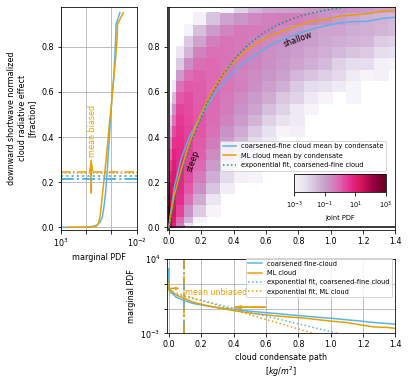

In [61]:
CONDENSATE_LIM = (-0.01, 1.4)
REFLECTION_ABSORPTION_LIM = (-0.01, 0.975)
MARGINAL_LOG_PDF_LIM = (-3, 4)

fig, axes = plt.subplots(nrows=2, ncols=2, gridspec_kw=dict(width_ratios=(1, 3), height_ratios=(3, 1)))
axes[0][0].set_prop_cycle(color=[COLOR_CYCLE[i] for i in [0, 1]])
coarsened_fine_cloud_marginal_density_reflection_absorption.plot(ax=axes[0][0], y='downward_shortwave_cre', xincrease=False)
predicted_cloud_marginal_density_reflection_absorption.plot(ax=axes[0][0], y='downward_shortwave_cre', xincrease=False)
axes[0][0].plot([10**i for i in [3, -2]], [
    coarsened_fine_cloud_downward_shortwave_cre_mean,
    coarsened_fine_cloud_downward_shortwave_cre_mean
], lw=2, ls='-.')
axes[0][0].plot([10**i for i in [3, -2]], [
    predicted_cloud_downward_shortwave_cre_mean,
    predicted_cloud_downward_shortwave_cre_mean
], ls='-.')
axes[0][0].plot([10**i for i in [3, -2]], [
    coarsened_fine_cloud_cre_expected,
    coarsened_fine_cloud_cre_expected
], lw=2, ls=':')
axes[0][0].plot([10**i for i in [3, -2]], [
    predicted_cloud_cre_expected,
    predicted_cloud_cre_expected
], ls=':')
axes[0][0].set_xscale('log')
axes[0][0].set_xticks(np.logspace(3, -2, 4))
axes[0][0].set_xlabel('marginal PDF')
axes[0][0].set_xlim([10**i for i in [3, -2]])
axes[0][0].set_ylim(*REFLECTION_ABSORPTION_LIM)
axes[0][0].grid()
axes[0][0].arrow(
    10, 0.15, 0, 0.1,
    head_width=5, head_length=0.05, edgecolor=COLOR_CYCLE[1], facecolor=COLOR_CYCLE[1]
)
axes[0][0].text(15, 0.32, 'mean biased', rotation='vertical', color=COLOR_CYCLE[1])
X, Y = xr.broadcast(
    coarsened_fine_cloud_density.column_integrated_cloud_condensate_mixing_ratio,
    coarsened_fine_cloud_density.downward_shortwave_cre,
)
h = axes[0][1].pcolormesh(
    X,
    Y,
    coarsened_fine_cloud_density,
    norm=LogNorm(vmin=10**-3, vmax=10**3),
    cmap='PuRd'
)
axes[0][1].plot([0, 0], REFLECTION_ABSORPTION_LIM, 'k')
axes[0][1].plot(CONDENSATE_LIM, [0, 0], 'k')
axes[0][1].set_prop_cycle(color=[COLOR_CYCLE[i] for i in [0, 1, 2]])
hcm, = coarsened_fine_cloud_downward_shortwave_cre_mean_by_condensate.plot(ax=axes[0][1])
hpm, = predicted_cloud_downward_shortwave_cre_mean_by_condensate.plot(ax=axes[0][1])
best_fit_coarsened_fine = (1 - np.exp(-coarsened_fine_cloud_marginal_density_condensate.column_integrated_cloud_condensate_mixing_ratio/c0_coarsened_fine))
hcb, = best_fit_coarsened_fine.plot(ax=axes[0][1], ls=':')
axes[0][1].text(0.1, 0.25, 'steep', color='k', rotation=70)
axes[0][1].text(0.7, 0.8, 'shallow', color='k', rotation=20)
axes[0][1].legend(
    [hcm, hpm, hcb],
    ['coarsened-fine cloud mean by condensate', 'ML cloud mean by condensate', 'exponential fit, coarsened-fine cloud'],
    loc='lower right',
    bbox_to_anchor=(-0.025, 0.25, 1, 1),
    fontsize='small'
)
axins = inset_axes(
    axes[0][1],
    width="40%",
    height="8%",
    loc="lower right",
    bbox_to_anchor=(-0.025, 0.15, 1, 1),
    bbox_transform=axes[0][1].transAxes,
)
cb = plt.colorbar(h, cax=axins, orientation='horizontal')
cb.set_label(label='joint PDF', size='small')
cb.ax.tick_params(labelsize='small')
axes[0][1].set_xlim(*CONDENSATE_LIM)
axes[0][1].set_ylim(*REFLECTION_ABSORPTION_LIM)
axes[0][1].set_xlabel('')
axes[0][1].set_ylabel('')
axes[1][0].set_axis_off()
axes[1][1].set_prop_cycle(color=[COLOR_CYCLE[i] for i in [0, 1]])
coarsened_fine_cloud_marginal_density_condensate.plot(ax=axes[1][1])
predicted_cloud_marginal_density_condensate.plot(ax=axes[1][1])
(coarsened_fine_exp_dist).plot(ax=axes[1][1], ls=':')
(predicted_exp_dist).plot(ax=axes[1][1], ls=':')
axes[1][1].plot([
    coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean,
    coarsened_fine_cloud_column_integrated_cloud_condensate_mixing_ratio_mean
], [10**i for i in MARGINAL_LOG_PDF_LIM], lw=2, ls='-.')
axes[1][1].plot([
    predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean,
    predicted_cloud_column_integrated_cloud_condensate_mixing_ratio_mean
], [10**i for i in MARGINAL_LOG_PDF_LIM], ls='-.')
axes[1][1].legend(['coarsened fine-cloud', 'ML cloud', 'exponential fit, coarsened-fine cloud', 'exponential fit, ML cloud'], loc='center right', bbox_to_anchor=(0, 0.25, 1, 1), fontsize='small')
axes[1][1].set_xlim(*CONDENSATE_LIM)
axes[1][1].set_yscale('log')
axes[1][1].set_yticks(np.logspace(*MARGINAL_LOG_PDF_LIM, 4))
axes[1][1].set_ylabel('marginal PDF')
axes[1][1].set_ylim([10**i for i in MARGINAL_LOG_PDF_LIM])
axes[1][1].grid()
axes[1][1].arrow(
    0, 10**1.25, 0.04, 0,
    head_width=10, head_length=0.02, edgecolor=COLOR_CYCLE[1], facecolor=COLOR_CYCLE[1]
)
axes[1][1].arrow(
    0.6, 0.3, -0.15, 0,
    head_width=0.2, head_length=0.05, edgecolor=COLOR_CYCLE[1], facecolor=COLOR_CYCLE[1]
)
axes[1][1].text(0.1, 4, 'mean unbiased', color=COLOR_CYCLE[1])
fig.set_size_inches([6, 6])
fig.savefig(f'./{OUTDIR}/condensate_vs_downward_shortwave_CRE.eps', bbox_inches='tight')